
# Deep Learning with Differential Privacy on MNIST

This notebook reproduces and extends the experiment from Abadi et al. (2016) using TensorFlow Privacy.  
It compares model performance with and without Differential Privacy (DP), using the MNIST dataset.

**Goals**:
- Evaluate the impact of DP on accuracy.
- Compare multiple noise multipliers.
- Plot ε vs accuracy.


In [1]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.astype(np.int32), y_test.astype(np.int32)


2025-04-11 12:31:36.556528: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 12:31:36.641311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 12:31:36.642773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 12:31:37.604123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The model is a simple feedforward neural network, consistent with the Abadi et al. paper, and appropriate for a small dataset like MNIST.

In [2]:

def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10)
    ])
    return model


In [3]:

def train_model(dp=True, noise_multiplier=1.1, epochs=10):
    model = create_model()
    metrics = ['accuracy']

    if dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=1.0,
            noise_multiplier=noise_multiplier,
            num_microbatches=250,
            learning_rate=0.15)
    else:
        # Option to train the model without differential privacy for comparison
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.15)

    if dp:
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )
    else:
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
        )

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.fit(x_train, y_train,
              epochs=epochs,
              validation_data=(x_test, y_test),
              batch_size=250,
              verbose=2)

    _, acc = model.evaluate(x_test, y_test, verbose=0)

    if dp:
        eps, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=x_train.shape[0],
            batch_size=250,
            noise_multiplier=noise_multiplier,
            epochs=epochs,
            delta=1e-5)
    else:
        eps = float('inf')

    return eps, acc


In [4]:

print("Running baseline (no differential privacy)...")
baseline_eps, baseline_acc = train_model(dp=False)
print(f"Baseline accuracy: {baseline_acc:.4f} (ε = ∞)")


Running baseline (no differential privacy)...


2025-04-11 12:31:41.302040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-11 12:31:41.302518: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
240/240 - 1s - loss: 0.5271 - accuracy: 0.8571 - val_loss: 0.3010 - val_accuracy: 0.9166 - 1s/epoch - 4ms/step
Epoch 2/10
240/240 - 1s - loss: 0.2854 - accuracy: 0.9182 - val_loss: 0.2440 - val_accuracy: 0.9312 - 587ms/epoch - 2ms/step
Epoch 3/10
240/240 - 1s - loss: 0.2361 - accuracy: 0.9335 - val_loss: 0.2102 - val_accuracy: 0.9406 - 581ms/epoch - 2ms/step
Epoch 4/10
240/240 - 1s - loss: 0.2038 - accuracy: 0.9428 - val_loss: 0.1896 - val_accuracy: 0.9443 - 604ms/epoch - 3ms/step
Epoch 5/10
240/240 - 1s - loss: 0.1800 - accuracy: 0.9496 - val_loss: 0.1694 - val_accuracy: 0.9515 - 596ms/epoch - 2ms/step
Epoch 6/10
240/240 - 1s - loss: 0.1614 - accuracy: 0.9549 - val_loss: 0.1563 - val_accuracy: 0.9547 - 1s/epoch - 5ms/step
Epoch 7/10
240/240 - 1s - loss: 0.1465 - accuracy: 0.9590 - val_loss: 0.1407 - val_accuracy: 0.9588 - 941ms/epoch - 4ms/step
Epoch 8/10
240/240 - 1s - loss: 0.1343 - accuracy: 0.9623 - val_loss: 0.1324 - val_accuracy: 0.9602 - 786ms/epoch - 3ms/step
Epoch 

In [5]:

noise_multipliers = [0.5, 1.1, 2.0, 3.0]
dp_results = []

for nm in noise_multipliers:
    print(f"Training with noise_multiplier = {nm}")
    eps, acc = train_model(dp=True, noise_multiplier=nm)
    dp_results.append({'noise_multiplier': nm, 'epsilon': eps, 'accuracy': acc})


Training with noise_multiplier = 0.5
Epoch 1/10
240/240 - 33s - loss: 1.2568 - accuracy: 0.6445 - val_loss: 0.6807 - val_accuracy: 0.7968 - 33s/epoch - 139ms/step
Epoch 2/10
240/240 - 31s - loss: 0.5728 - accuracy: 0.8206 - val_loss: 0.4738 - val_accuracy: 0.8500 - 31s/epoch - 127ms/step
Epoch 3/10
240/240 - 32s - loss: 0.4627 - accuracy: 0.8565 - val_loss: 0.4172 - val_accuracy: 0.8731 - 32s/epoch - 132ms/step
Epoch 4/10
240/240 - 30s - loss: 0.4279 - accuracy: 0.8721 - val_loss: 0.3936 - val_accuracy: 0.8842 - 30s/epoch - 123ms/step
Epoch 5/10
240/240 - 34s - loss: 0.4130 - accuracy: 0.8808 - val_loss: 0.3838 - val_accuracy: 0.8926 - 34s/epoch - 141ms/step
Epoch 6/10
240/240 - 34s - loss: 0.4039 - accuracy: 0.8870 - val_loss: 0.3774 - val_accuracy: 0.8980 - 34s/epoch - 141ms/step
Epoch 7/10
240/240 - 35s - loss: 0.3986 - accuracy: 0.8915 - val_loss: 0.3727 - val_accuracy: 0.9015 - 35s/epoch - 144ms/step
Epoch 8/10
240/240 - 34s - loss: 0.3946 - accuracy: 0.8953 - val_loss: 0.3706 - v

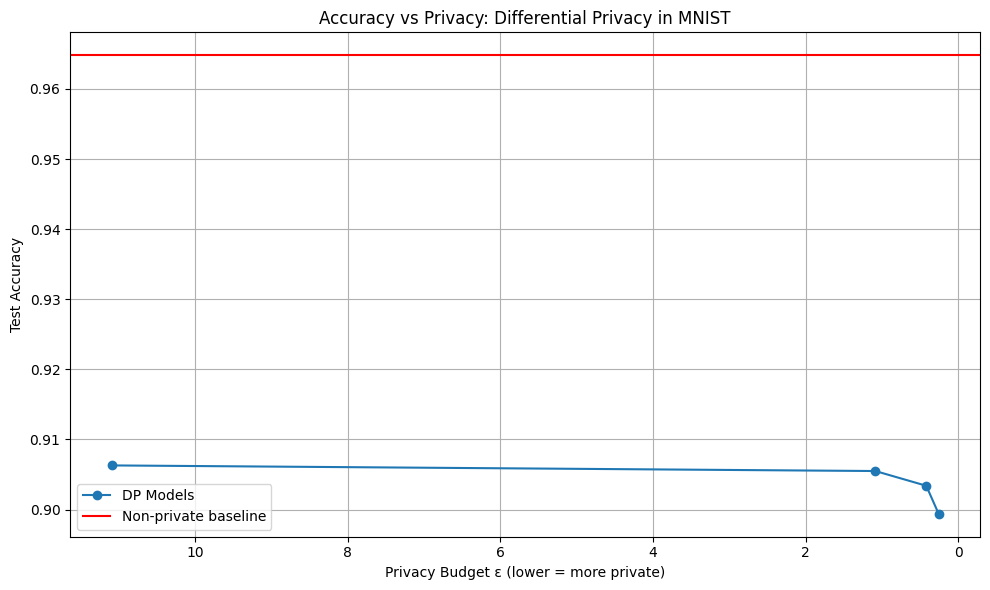

  Noise Multiplier  Final Accuracy Epsilon (Privacy Budget)
0              0.5          0.9063                11.091833
1              1.1          0.9055                 1.088233
2              2.0          0.9034                 0.421371
3              3.0          0.8994                 0.259054
4  ∞ (Non-private)          0.9648                        ∞


In [6]:

epsilons = [r["epsilon"] for r in dp_results]
accuracies = [r["accuracy"] for r in dp_results]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o', label='DP Models')
plt.axhline(y=baseline_acc, color='red', label='Non-private baseline')
plt.xlabel("Privacy Budget ε (lower = more private)")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Privacy: Differential Privacy in MNIST")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

import pandas as pd

# Prepare data for the table
dp_results_table = []
for result in dp_results:
    dp_results_table.append({
        'Noise Multiplier': result["noise_multiplier"],
        'Final Accuracy': result["accuracy"],
        'Epsilon (Privacy Budget)': result["epsilon"]
    })

# Add baseline result to the table
dp_results_table.append({
    'Noise Multiplier': '∞ (Non-private)',
    'Final Accuracy': baseline_acc,
    'Epsilon (Privacy Budget)': '∞'
})

# Convert to pandas DataFrame for better formatting
results_df = pd.DataFrame(dp_results_table)

# Display the table
print(results_df)
